<h1>LightGBM Models Training</h1>
<h3>WIDS 2024 Challenge ++</h3>
<h3>BMI 212 - Team DMMTS</h3>

In [100]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn import preprocessing
pd.set_option("mode.copy_on_write", True)

<h4> Load the data</h4>

In [101]:
# Load the CSV dataset
data_df = pd.read_csv('./Data/train_test_added_climate_data_imputed.csv')

# Rename feature columns for better readability
data_df.rename(columns={'bmi': 'patient_bmi',
                   'region': 'patient_region',
                   'division': 'patient_division',
                   'side': 'patient_tumor_side',
                   'quadrant': 'patient_tumor_quadrant',
                   'metastatic_organ': 'patient_metastatic_organ',
                   'cleaned_metastatic_first_treatment': 'patient_metastatic_first_treatment',
                   'cleaned_metastatic_first_treatment_type': 'patient_metastatic_first_treatment_type',
                   'population': 'population_size',
                   'density': 'population_density',
                   'age_median': 'population_age_median',
                   'female': 'population_female_perc',
                   'married': 'population_married_perc',
                   'divorced': 'population_divorced_perc',
                   'never_married': 'population_never_married_perc',
                   'widowed': 'population_widowed_perc',
                   'family_size': 'population_family_size',
                   'family_dual_income': 'population_family_dual_income_perc',
                   'income_individual_median': 'population_income_individual_median',
                   'income_household_median': 'population_income_household_median',
                   'home_ownership': 'population_home_ownership_perc',
                   'home_value': 'population_home_value',
                   'rent_median': 'population_rent_median',
                   'rent_burden': 'population_rent_burden_perc',
                   'education_less_highschool': 'population_education_less_highschool_perc',
                   'education_highschool': 'population_education_highschool_perc',
                   'education_some_college': 'population_education_some_college_perc',
                   'education_bachelors': 'population_education_bachelors_perc',
                   'education_graduate': 'population_education_graduate_perc',
                   'education_college_or_above': 'population_education_college_or_above_perc',
                   'education_stem_degree': 'population_education_stem_degree_perc',
                   'unemployment_rate': 'population_unemployment_rate',
                   'self_employed': 'population_self_employed_perc',
                   'farmer': 'population_farmer_perc',
                   'race_white': 'population_race_white_perc',
                   'race_black': 'population_race_black_perc',
                   'race_asian': 'population_race_asian_perc',
                   'race_native': 'population_race_native_american_perc',
                   'race_pacific': 'population_race_pacific_islander_perc',
                   'race_other': 'population_race_other_perc',
                   'race_multiple': 'population_race_multiple_perc',
                   'hispanic': 'population_hispanic_perc',
                   'disabled': 'population_disabled_perc',
                   'poverty': 'population_poverty_perc',
                   'limited_english': 'population_limited_english_perc',
                   'commute_time': 'population_commute_time',
                   'health_uninsured': 'population_health_uninsured_perc',
                   'veteran': 'population_veteran_perc',
                    'climate_ozone': 'annual_ozone_conc',
                    'climate_pm25': 'annual_fine_particulate_matter_conc',
                    'climate_n02': 'annual_nitrogen_dioxide_conc'
                   }, inplace=True)

<h4>Select the features to use</h4>

In [102]:
features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'patient_gender', 'patient_bmi',
            'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant',
            'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type',
            'population_size', 'population_density', 'population_age_median', 'population_female_perc',
            'population_married_perc', 'population_divorced_perc', 'population_never_married_perc',
            'population_widowed_perc', 'population_family_size', 'population_family_dual_income_perc',
            'population_income_individual_median', 'population_income_household_median', 'population_home_ownership_perc',
            'population_home_value', 'population_rent_median', 'population_rent_burden_perc',
            'population_education_less_highschool_perc', 'population_education_highschool_perc',
            'population_education_some_college_perc', 'population_education_bachelors_perc',
            'population_education_graduate_perc', 'population_education_college_or_above_perc',
            'population_education_stem_degree_perc', 'population_unemployment_rate', 'population_self_employed_perc',
            'population_farmer_perc', 'population_race_white_perc', 'population_race_black_perc',
            'population_race_asian_perc', 'population_race_native_american_perc', 'population_race_pacific_islander_perc',
            'population_race_other_perc', 'population_race_multiple_perc', 'population_hispanic_perc',
            'population_disabled_perc', 'population_poverty_perc', 'population_limited_english_perc',
            'population_commute_time', 'population_health_uninsured_perc', 'population_veteran_perc', 'annual_nitrogen_dioxide_conc',
            'annual_fine_particulate_matter_conc', 'annual_ozone_conc']

# Select only rows where allocated_set is train
train_df = data_df[data_df['allocated_set'] == 'train']
train_df.head()

# Select the features to use
features_df = train_df[features]

# Extract labels for time to treatment 
labels_df = train_df[['treatment_pd']]

In [103]:
features_df['patient_bmi'].value_counts()

patient_bmi
27.00    763
40.00    701
24.00    511
26.00    495
23.00    472
        ... 
38.07      1
39.83      1
33.04      1
20.86      1
43.68      1
Name: count, Length: 1935, dtype: int64

<h4>Define categorical variables</h4>

In [105]:
# Convert object features to categorical
for col in features_df.select_dtypes(include='object').columns:
    features_df[col] = features_df[col].astype('category')

# List of categorical features
categorical_features = list(features_df.select_dtypes(include='category').columns)
print(categorical_features)

['patient_race', 'payer_type', 'patient_state', 'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant', 'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type']


In [106]:
# Note: Significant portion of race data is missing! Double-check that they have been imputed.
features_df['patient_race'].value_counts(dropna=False)

patient_race
White       14577
Black        4713
Other        3917
Hispanic     3173
Asian        1294
Name: count, dtype: int64

<h4>Drop low-variance features</h4>

In [107]:
# Temporarily convert categorical features to distinct numerical codes, keeping missing/NaN values
temp_feature_df = features_df.copy()
for cat_feat in categorical_features:
    temp_feature_df[cat_feat] = temp_feature_df[cat_feat].cat.codes
    temp_feature_df.loc[temp_feature_df[cat_feat] == -1] = np.NaN

In [108]:
temp_feature_df.head()

patient_race  payer_type  patient_state  patient_age  patient_gender  \
0             0           0              4           46           False   
1             4           2             35           63           False   
2             2           0             44           53           False   
3             2           1              4           50           False   
4             3           0             34           39           False   

   patient_bmi  patient_region  patient_division  patient_tumor_side  \
0        27.00               3                 5                   1   
1        27.82               0                 0                   0   
2        27.12               2                 8                   0   
3        26.42               3                 5                   2   
4        18.00               1                 2                   2   

   patient_tumor_quadrant  ...  population_hispanic_perc  \
0                       7  ...                 47.726087   
1                       3  ...                  1.182979   
2                       2  ...                 21.064151   
3                       8  ...                 37.948485   
4                       8  ...                 18.960526   

   population_disabled_perc  population_poverty_perc  \
0                  9.895652                10.515217   
1                 18.317021                13.546809   
2                 14.083019                11.943396   
3                  8.957576                10.109091   
4                 10.194737                18.642105   

   population_limited_english_perc  population_commute_time  \
0                        12.745652                32.530435   
1                         0.146809                31.890909   
2                         2.549057                32.556250   
3                         8.057576                30.606061   
4                        14.173684                42.502632   

   population_health_uninsured_perc  population_veteran_perc  \
0                          7.263043                 3.810870   
1                          7.631915                 9.631915   
2                         16.396226                10.392453   
3                          7.018182                 4.103030   
4                          6.392105                 1.755263   

   annual_nitrogen_dioxide_conc  annual_fine_particulate_matter_conc  \
0                     20.084231                             9.595719   
1                     12.485563                             8.399666   
2                     11.522807                             9.361774   
3                     20.113179                             8.487175   
4                     27.496367                             7.879795   

   annual_ozone_conc  
0          47.310325  
1          40.544389  
2          38.696786  
3          42.301121  
4          37.722740  

[5 rows x 56 columns]

In [109]:
from sklearn.feature_selection import VarianceThreshold

# Remove low-var features from temp df (will drop removed cols from original df)
low_var_filter = VarianceThreshold(threshold=(.9 * (1 - .9)))
filtered_features = low_var_filter.fit_transform(temp_feature_df)
filtered_feature_names = low_var_filter.get_feature_names_out(input_features=features)
print("Low-variance features: ", set(features) - set(filtered_feature_names))

filtered_features_df = features_df[filtered_feature_names].copy()

Low-variance features:  {'patient_gender', 'patient_metastatic_first_treatment_type', 'population_family_size'}


In [110]:
filtered_features_df['patient_bmi'].value_counts()

patient_bmi
27.00    763
40.00    701
24.00    511
26.00    495
23.00    472
        ... 
38.07      1
39.83      1
33.04      1
20.86      1
43.68      1
Name: count, Length: 1935, dtype: int64

<h4>Remove features with >60% missing data</h4>

In [111]:
dropped_cols = []
for col in filtered_features_df.columns:
    percent_missing = filtered_features_df[col].isnull().sum() / len(filtered_features_df[col])
    if percent_missing > 0.6:
        dropped_cols.append(col)
        filtered_features_df.drop(columns=[col], inplace=True)
print("Dropped features: ", dropped_cols)

Dropped features:  []


<h4>Impute data</h4>

In [112]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [113]:
filtered_features_df['patient_race'].value_counts(normalize=True, dropna=False)

patient_race
White       0.526740
Black       0.170304
Other       0.141541
Hispanic    0.114656
Asian       0.046759
Name: proportion, dtype: float64

In [114]:
# Identify numerical features 
numerical_features = list(filtered_features_df.select_dtypes(include='number').columns)

# Impute numerical features (estimates each feature from others)
imputer = IterativeImputer()
imputed_num_data = imputer.fit_transform(filtered_features_df[numerical_features])
imputed_num_df = pd.DataFrame(imputed_num_data, columns=numerical_features)
imputed_num_df.head()

patient_age  patient_bmi  population_size  population_density  \
0         46.0        27.00          43031.0         2048.578261   
1         63.0        27.82           7228.0          194.656250   
2         53.0        27.12          24751.0          352.226786   
3         50.0        26.42          39122.0         2295.939394   
4         39.0        18.00          71374.0        17326.407890   

   population_age_median  population_female_perc  population_married_perc  \
0              38.852174               50.947826                48.504348   
1              41.247826               47.908511                50.672340   
2              41.371154               50.645283                52.994340   
3              38.200000               50.106061                50.245455   
4              36.476316               52.331579                39.923684   

   population_divorced_perc  population_never_married_perc  \
0                 10.117391                      36.408696   
1                 14.102128                      27.117021   
2                 13.341509                      25.094340   
3                  9.827273                      35.290909   
4                 10.239474                      44.642105   

   population_widowed_perc  ...  population_hispanic_perc  \
0                 4.969565  ...                 47.726087   
1                 8.112766  ...                  1.182979   
2                 8.579245  ...                 21.064151   
3                 4.651515  ...                 37.948485   
4                 5.186842  ...                 18.960526   

   population_disabled_perc  population_poverty_perc  \
0                  9.895652                10.515217   
1                 18.317021                13.546809   
2                 14.083019                11.943396   
3                  8.957576                10.109091   
4                 10.194737                18.642105   

   population_limited_english_perc  population_commute_time  \
0                        12.745652                32.530435   
1                         0.146809                31.890909   
2                         2.549057                32.556250   
3                         8.057576                30.606061   
4                        14.173684                42.502632   

   population_health_uninsured_perc  population_veteran_perc  \
0                          7.263043                 3.810870   
1                          7.631915                 9.631915   
2                         16.396226                10.392453   
3                          7.018182                 4.103030   
4                          6.392105                 1.755263   

   annual_nitrogen_dioxide_conc  annual_fine_particulate_matter_conc  \
0                     20.084231                             9.595719   
1                     12.485563                             8.399666   
2                     11.522807                             9.361774   
3                     20.113179                             8.487175   
4                     27.496367                             7.879795   

   annual_ozone_conc  
0          47.310325  
1          40.544389  
2          38.696786  
3          42.301121  
4          37.722740  

[5 rows x 44 columns]

In [115]:
# Set numeric columns in filtered features df to imputed columns
for col in numerical_features:
    filtered_features_df.loc[:, col] = imputed_num_df[col]
filtered_features_df.head()

patient_race          payer_type patient_state  patient_age  patient_bmi  \
0        Asian          COMMERCIAL            CA           46        27.00   
1        White  MEDICARE ADVANTAGE            OH           63        27.82   
2     Hispanic          COMMERCIAL            TX           53        27.12   
3     Hispanic            MEDICAID            CA           50        26.42   
4        Other          COMMERCIAL            NY           39        18.00   

  patient_region    patient_division patient_tumor_side  \
0           West             Pacific                  R   
1        Midwest  East North Central                  L   
2          South  West South Central                  L   
3           West             Pacific        unspecified   
4      Northeast     Middle Atlantic        unspecified   

  patient_tumor_quadrant           patient_metastatic_organ  ...  \
0                overlap            lymph node, unspecified  ...   
1                     UO                               bone  ...   
2                     UI  axilla and upper limb lymph nodes  ...   
3            unspecified                              liver  ...   
4            unspecified                        unspecified  ...   

  population_hispanic_perc  population_disabled_perc  population_poverty_perc  \
0                47.726087                  9.895652                10.515217   
1                 1.182979                 18.317021                13.546809   
2                21.064151                 14.083019                11.943396   
3                37.948485                  8.957576                10.109091   
4                18.960526                 10.194737                18.642105   

   population_limited_english_perc  population_commute_time  \
0                        12.745652                32.530435   
1                         0.146809                31.890909   
2                         2.549057                32.556250   
3                         8.057576                30.606061   
4                        14.173684                42.502632   

   population_health_uninsured_perc  population_veteran_perc  \
0                          7.263043                 3.810870   
1                          7.631915                 9.631915   
2                         16.396226                10.392453   
3                          7.018182                 4.103030   
4                          6.392105                 1.755263   

   annual_nitrogen_dioxide_conc  annual_fine_particulate_matter_conc  \
0                     20.084231                             9.595719   
1                     12.485563                             8.399666   
2                     11.522807                             9.361774   
3                     20.113179                             8.487175   
4                     27.496367                             7.879795   

   annual_ozone_conc  
0          47.310325  
1          40.544389  
2          38.696786  
3          42.301121  
4          37.722740  

[5 rows x 53 columns]

# Split into train/test 80/20

In [116]:
# Rename dfs of features and target
X = filtered_features_df
y = labels_df

<h4>30-day labels</h4>

In [117]:
# Create labels for >30 days time to treatment
labels_30 = labels_df.copy()
labels_30.loc[labels_30['treatment_pd'] > 30, 'label'] = 1 
labels_30.loc[labels_30['treatment_pd'] <= 30, 'label'] = 0 
labels_30.head()

treatment_pd  label
0          35.0    1.0
1          33.0    1.0
2          24.0    0.0
3         455.0    1.0
4         162.0    1.0

In [118]:
y_30 = labels_30[['label']]

# Split the data into train/test split (80/20)
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X, y_30, test_size=0.2, random_state=123)

<h4>60-days labels</h4>

In [119]:
# Create labels for >30 days time to treatment
labels_60 = labels_df.copy()
labels_60.loc[labels_60['treatment_pd'] > 60, 'label'] = 1 
labels_60.loc[labels_60['treatment_pd'] <= 60, 'label'] = 0 
labels_60.head()

treatment_pd  label
0          35.0    0.0
1          33.0    0.0
2          24.0    0.0
3         455.0    1.0
4         162.0    1.0

In [120]:
y_60 = labels_60[['label']]

# Split the data into train/test split (80/20)
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(X, y_60, test_size=0.2, random_state=123)

<h4>90-days labels</h4>

In [121]:
# Create labels for >90 days time to treatment
labels_90 = labels_df.copy()
labels_90.loc[labels_90['treatment_pd'] > 90, 'label'] = 1 
labels_90.loc[labels_90['treatment_pd'] <= 90, 'label'] = 0 
labels_90.head()

treatment_pd  label
0          35.0    0.0
1          33.0    0.0
2          24.0    0.0
3         455.0    1.0
4         162.0    1.0

In [122]:
y_90 = labels_90[['label']]

# Split the data into train/test split (80/20)
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X, y_90, test_size=0.2, random_state=123)

# Prep LightGBM dataset

<h4>30-day classification</h4>

In [123]:
# Create the LightGBM dataset
train_data_30 = lgb.Dataset(X_train_30, label=y_train_30, feature_name='auto', categorical_feature=categorical_features)
test_data_30 = lgb.Dataset(X_test_30, label=y_test_30, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a regression model
params = {
    'objective': ['binary'],
    'metric': ['rmse'], 
    'is_unbalanced': [True],
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model_30 = lgb.LGBMClassifier()

# Create the grid search
grid_30 = GridSearchCV(model_30, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_30.fit(X_train_30, y_train_30.values.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'is_unbalanced': [True], 'learning_rate': [0.1],
                         'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61], 'objective': ['binary'],
                         'verbose': [-1], 'verbosity': [-1]},
             scoring='roc_auc')

In [124]:
# Print best parameters
print('Best parameters:', grid_30.best_params_)

# Print best score
print('Best score:', grid_30.best_score_)

# Re-train LGB model with best params
best_lgbmodel_30 = lgb.LGBMClassifier(**grid_30.best_params_)
best_lgbmodel_30.fit(X_train_30, y_train_30.values.ravel())
y_test_pred_30 = best_lgbmodel_30.predict(X_test_30)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_30, y_pred=y_test_pred_30))

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'is_unbalanced': True, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'verbose': -1, 'verbosity': -1}
Best score: 0.6943078278204358
RMSE: 0.45759672268742574


In [125]:
# Alternate (original) form 

# Test the model
y_test_pred_OG_30 = grid_30.predict(X_test_30)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_30, y_pred=y_test_pred_OG_30))

RMSE: 0.45759672268742574


<h4>60-day classification</h4>

In [126]:
# Create the LightGBM dataset
train_data_60 = lgb.Dataset(X_train_60, label=y_train_60, feature_name='auto', categorical_feature=categorical_features)
test_data_60 = lgb.Dataset(X_test_60, label=y_test_60, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a regression model
params = {
    'objective': ['binary'],
    'metric': ['rmse'], 
    'is_unbalanced': [True],
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model_60 = lgb.LGBMClassifier()

# Create the grid search
grid_60 = GridSearchCV(model_60, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_60.fit(X_train_60, y_train_60.values.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'is_unbalanced': [True], 'learning_rate': [0.1],
                         'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61], 'objective': ['binary'],
                         'verbose': [-1], 'verbosity': [-1]},
             scoring='roc_auc')

In [127]:
# Print best parameters
print('Best parameters:', grid_60.best_params_)

# Print best score
print('Best score:', grid_60.best_score_)

# Re-train LGB model with best params
best_lgbmodel_60 = lgb.LGBMClassifier(**grid_60.best_params_)
best_lgbmodel_60.fit(X_train_60, y_train_60.values.ravel())
y_test_pred_60 = best_lgbmodel_60.predict(X_test_60)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_60, y_pred=y_test_pred_60))

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'is_unbalanced': True, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'verbose': -1, 'verbosity': -1}
Best score: 0.7211502089933228
RMSE: 0.5806267056153314


In [128]:
# Alternate (original) form 

# Test the model
y_test_pred_OG_60 = grid_60.predict(X_test_60)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_60, y_pred=y_test_pred_OG_60))

RMSE: 0.5806267056153314


<h4>90-day classification</h4>

In [129]:
# Create the LightGBM dataset
train_data_90 = lgb.Dataset(X_train_90, label=y_train_90, feature_name='auto', categorical_feature=categorical_features)
test_data_90 = lgb.Dataset(X_test_90, label=y_test_90, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a regression model
params = {
    'objective': ['binary'],
    'metric': ['rmse'], 
    'is_unbalanced': [True],
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model_90 = lgb.LGBMClassifier()

# Create the grid search
grid_90 = GridSearchCV(model_90, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_90.fit(X_train_90, y_train_90.values.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'is_unbalanced': [True], 'learning_rate': [0.1],
                         'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61], 'objective': ['binary'],
                         'verbose': [-1], 'verbosity': [-1]},
             scoring='roc_auc')

In [130]:
# Print best parameters
print('Best parameters:', grid_90.best_params_)

# Print best score
print('Best score:', grid_90.best_score_)

# Re-train LGB model with best params
best_lgbmodel_90 = lgb.LGBMClassifier(**grid_90.best_params_)
best_lgbmodel_90.fit(X_train_90, y_train_90.values.ravel())
y_test_pred_90 = best_lgbmodel_90.predict(X_test_90)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_90, y_pred=y_test_pred_90))

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'is_unbalanced': True, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'verbose': -1, 'verbosity': -1}
Best score: 0.7608147382642525
RMSE: 0.5091750772173156


In [131]:
# Alternate (original) form 

# Test the model
y_test_pred_OG_90 = grid_90.predict(X_test_90)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_90, y_pred=y_test_pred_OG_90))

RMSE: 0.5091750772173156


## Lasso/Lin Reg/Random Forest

In [132]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [133]:
# Note: Looks like we need to on-hot-encode categorical features for RandomForestRegressor to work
# 30-day train/test sets
onehot_feat_train_30 = pd.get_dummies(X_train_30, dummy_na = False)
onehot_feat_test_30 = pd.get_dummies(X_test_30, dummy_na = False)

# 60-day train/test sets
onehot_feat_train_60 = pd.get_dummies(X_train_60, dummy_na = False)
onehot_feat_test_60 = pd.get_dummies(X_test_60, dummy_na = False)

# 90-day train/test sets
onehot_feat_train_90 = pd.get_dummies(X_train_90, dummy_na = False)
onehot_feat_test_90 = pd.get_dummies(X_test_90, dummy_na = False)

<h4>Random Forest 30-days classification</h4>

In [134]:
rand_forest_30 = RandomForestClassifier()

# Fit the model to the data
rand_forest_30.fit(onehot_feat_train_30, y_train_30.values.ravel())

# Test the model
y_test_pred_rf_30 = rand_forest_30.predict(onehot_feat_test_30)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_30, y_pred=y_test_pred_rf_30))

# Pring ROC AUC 
print('ROCAUC:', roc_auc_score(y_true=y_test_30, y_score=y_test_pred_rf_30))

RMSE: 0.47121285397245993
ROCAUC: 0.5261405451170666


<h4>Random Forest 60-days classification</h4>

In [135]:
rand_forest_60 = RandomForestClassifier()

# Fit the model to the data
rand_forest_60.fit(onehot_feat_train_60, y_train_60.values.ravel())

# Test the model
y_test_pred_rf_60 = rand_forest_60.predict(onehot_feat_test_60)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_60, y_pred=y_test_pred_rf_60))

# Pring ROC AUC 
print('ROCAUC:', roc_auc_score(y_true=y_test_60, y_score=y_test_pred_rf_60))

RMSE: 0.607243241304675
ROCAUC: 0.6187888198757765


<h4>Random Forest 90-days classification</h4>

In [136]:
rand_forest_90 = RandomForestClassifier()

# Fit the model to the data
rand_forest_90.fit(onehot_feat_train_90, y_train_90.values.ravel())

# Test the model
y_test_pred_rf_90 = rand_forest_90.predict(onehot_feat_test_90)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_90, y_pred=y_test_pred_rf_90))

# Pring ROC AUC 
print('ROCAUC:', roc_auc_score(y_true=y_test_90, y_score=y_test_pred_rf_90))

RMSE: 0.5352944972025405
ROCAUC: 0.6751437921817703


<h4>Linear Regression 30-day classification</h4>

In [137]:
lin_reg_30 = LinearRegression()

# Fit the model to the data
lin_reg_30.fit(onehot_feat_train_30, y_train_30.values.ravel())

# Test the model
y_test_pred_lin_reg_30 = lin_reg_30.predict(onehot_feat_test_30)

# Print RMSE on test set
print('30-day RMSE:', root_mean_squared_error(y_true=y_test_30, y_pred=y_test_pred_lin_reg_30))

# Pring ROC AUC 
print('30-day ROCAUC:', roc_auc_score(y_true=y_test_30, y_score=y_test_pred_lin_reg_30))

30-day RMSE: 0.3920796690482983
30-day ROCAUC: 0.694683730597767


<h4>Linear Regression 60-day classification</h4>

In [138]:
lin_reg_60 = LinearRegression()

# Fit the model to the data
lin_reg_60.fit(onehot_feat_train_60, y_train_60.values.ravel())

# Test the model
y_test_pred_lin_reg_60 = lin_reg_60.predict(onehot_feat_test_60)

# Print RMSE on test set
print('60-day RMSE:', root_mean_squared_error(y_true=y_test_60, y_pred=y_test_pred_lin_reg_60))

# Pring ROC AUC 
print('60-day ROCAUC:', roc_auc_score(y_true=y_test_60, y_score=y_test_pred_lin_reg_60))

60-day RMSE: 0.46235875721937514
60-day ROCAUC: 0.7153921802834847


<h4>Linear Regression 90-day classification</h4>

In [139]:
lin_reg_90 = LinearRegression()

# Fit the model to the data
lin_reg_90.fit(onehot_feat_train_90, y_train_90.values.ravel())

# Test the model
y_test_pred_lin_reg_90 = lin_reg_90.predict(onehot_feat_test_90)

# Print RMSE on test set
print('90-day RMSE:', root_mean_squared_error(y_true=y_test_90, y_pred=y_test_pred_lin_reg_90))

# Pring ROC AUC 
print('90-day ROCAUC:', roc_auc_score(y_true=y_test_90, y_score=y_test_pred_lin_reg_90))

90-day RMSE: 0.4319479074255897
90-day ROCAUC: 0.7649228989570104


<h4>LASSO 30-day classification</h4>

In [140]:
log_reg_30 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
log_reg_30.fit(onehot_feat_train_30, y_train_30.values.ravel())

# Test the model
y_test_pred_log_reg_30 = log_reg_30.predict(onehot_feat_test_30)

# Print RMSE on test set
print('30-day RMSE:', root_mean_squared_error(y_true=y_test_30, y_pred=y_test_pred_log_reg_30))

# Pring ROC AUC 
print('30-day ROCAUC:', roc_auc_score(y_true=y_test_30, y_score=y_test_pred_log_reg_30))

30-day RMSE: 0.4560147068104949
30-day ROCAUC: 0.5044815852030349


<h4>LASSO 60-day classification</h4>

In [141]:
log_reg_60 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
log_reg_60.fit(onehot_feat_train_60, y_train_60.values.ravel())

# Test the model
y_test_pred_log_reg_60 = log_reg_60.predict(onehot_feat_test_60)

# Print RMSE on test set
print('60-day RMSE:', root_mean_squared_error(y_true=y_test_60, y_pred=y_test_pred_log_reg_60))

# Pring ROC AUC 
print('60-day ROCAUC:', roc_auc_score(y_true=y_test_60, y_score=y_test_pred_log_reg_60))

60-day RMSE: 0.5858925664041662
60-day ROCAUC: 0.6508819079471253


<h4>LASSO 90-day classification</h4>

In [142]:
log_reg_90 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
log_reg_90.fit(onehot_feat_train_90, y_train_90.values.ravel())

# Test the model
y_test_pred_log_reg_90 = log_reg_90.predict(onehot_feat_test_90)

# Print RMSE on test set
print('90-day RMSE:', root_mean_squared_error(y_true=y_test_90, y_pred=y_test_pred_log_reg_90))

# Pring ROC AUC 
print('90-day ROCAUC:', roc_auc_score(y_true=y_test_90, y_score=y_test_pred_log_reg_90))

90-day RMSE: 0.5156975787932896
90-day ROCAUC: 0.6889793989967173


# SHAP Values

In [143]:
import shap
shap.initjs()

In [144]:
# Ref: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
explainer = shap.TreeExplainer(best_lgbmodel_30)
shap_values = explainer(X)
shap.force_plot(explainer.expected_value, shap_values.values[1, :], X.iloc[0, :])

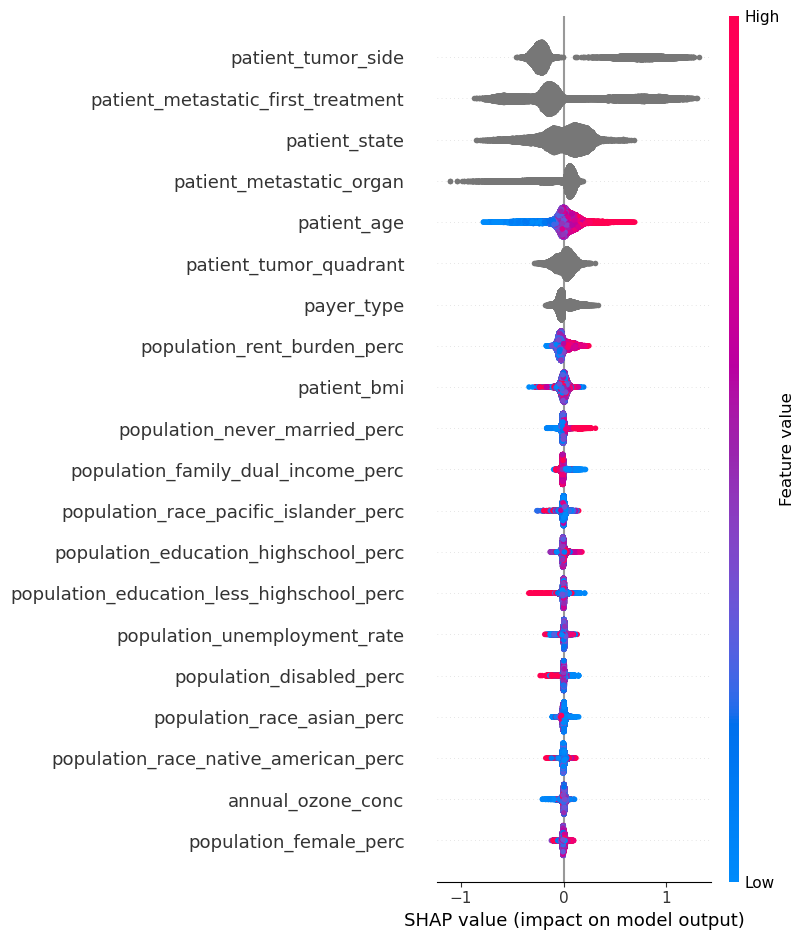

In [145]:
shap.summary_plot(shap_values, X)

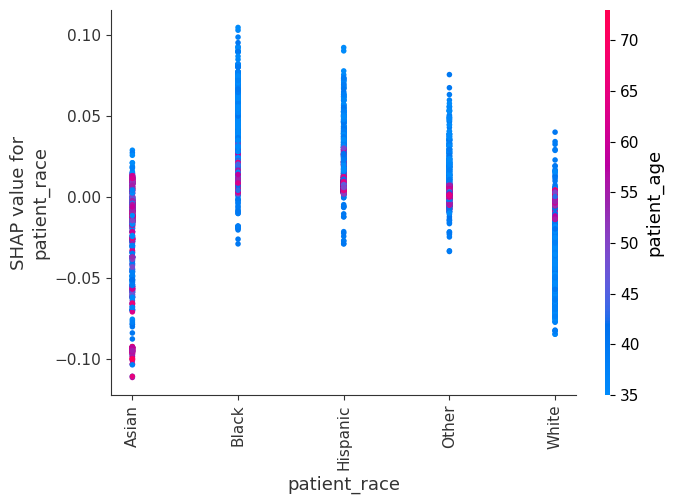

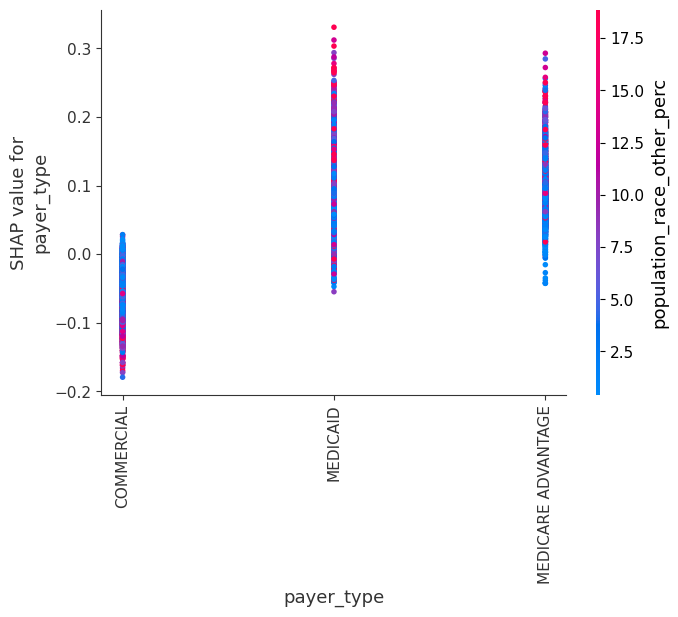

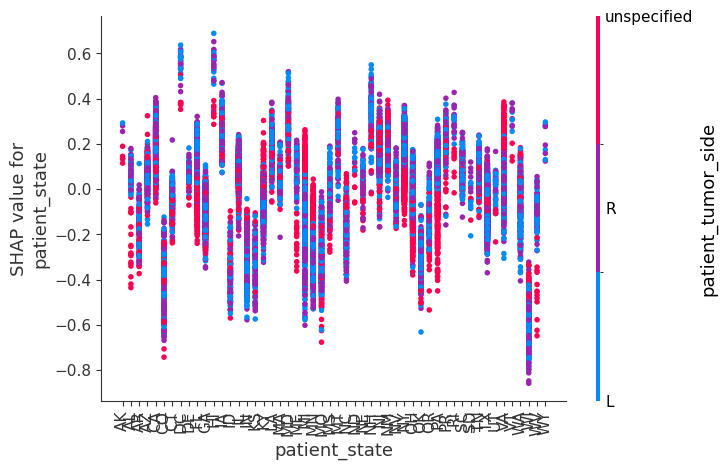

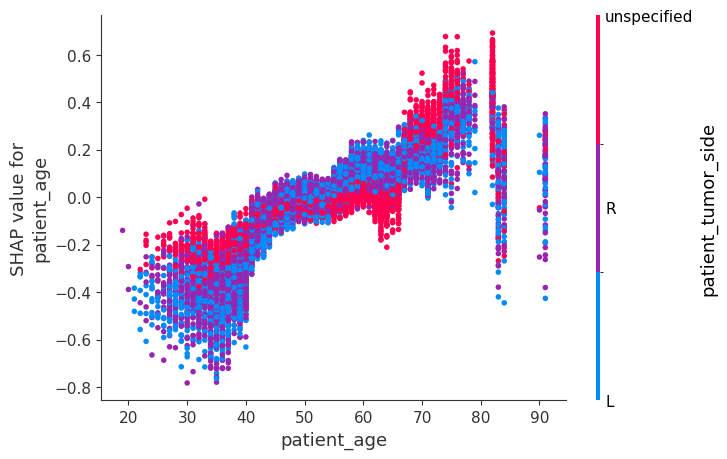

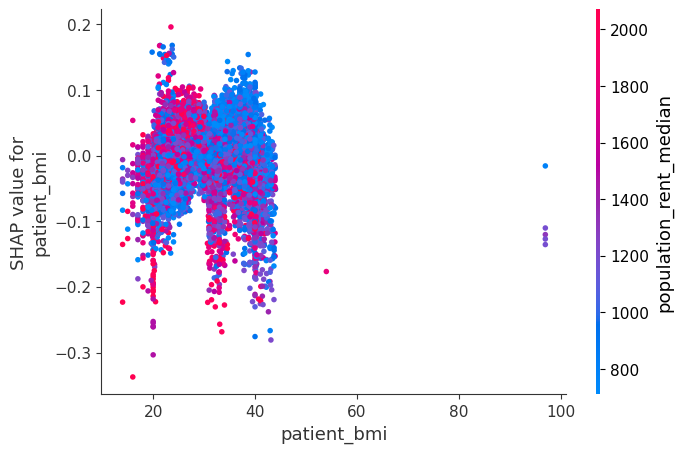

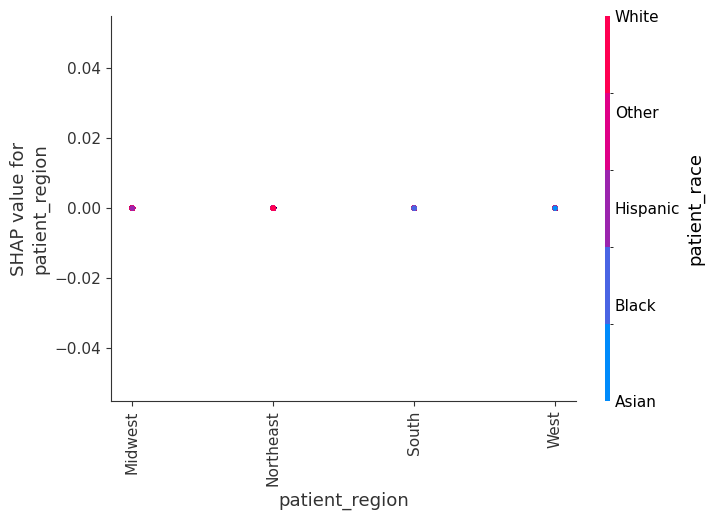

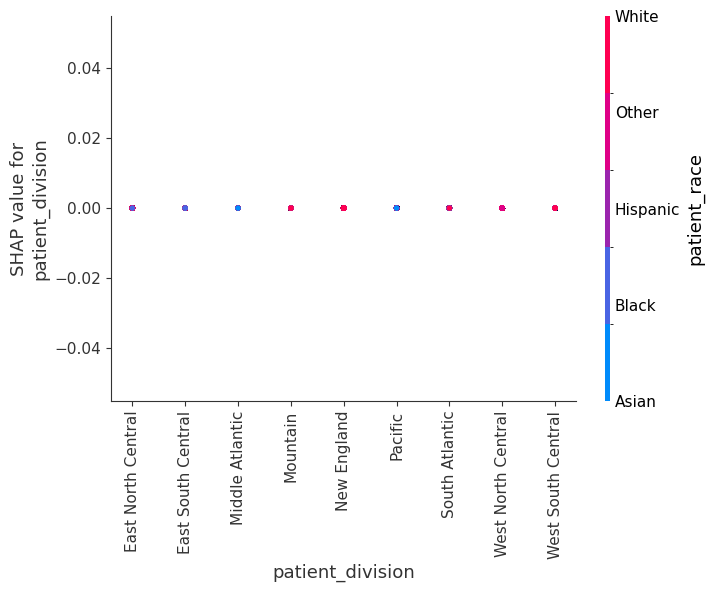

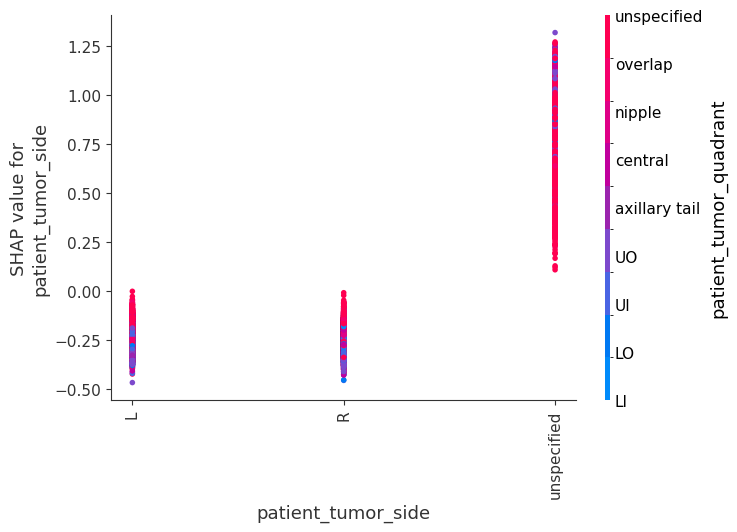

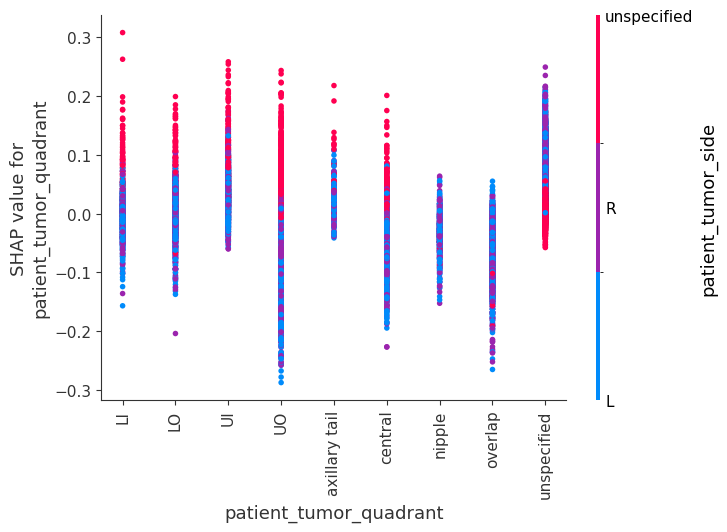

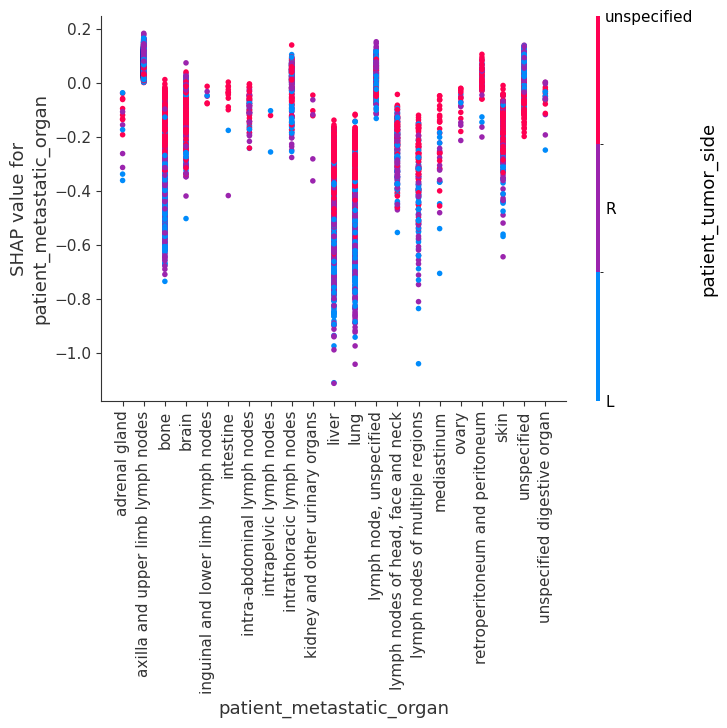

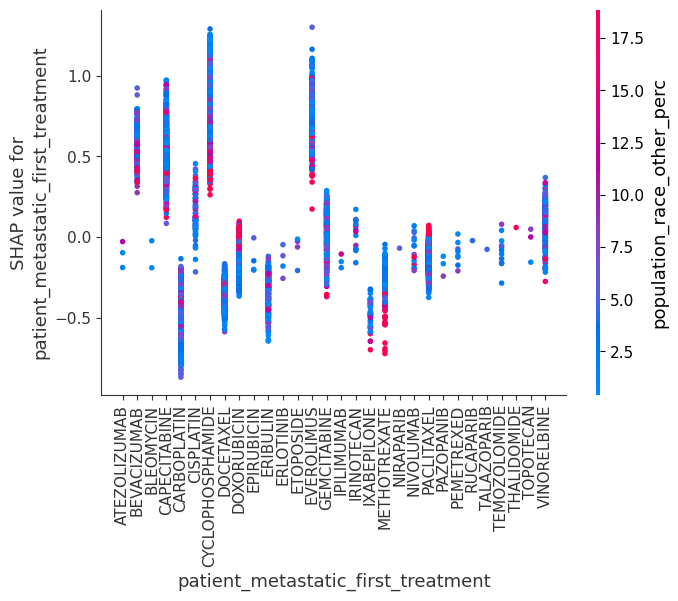

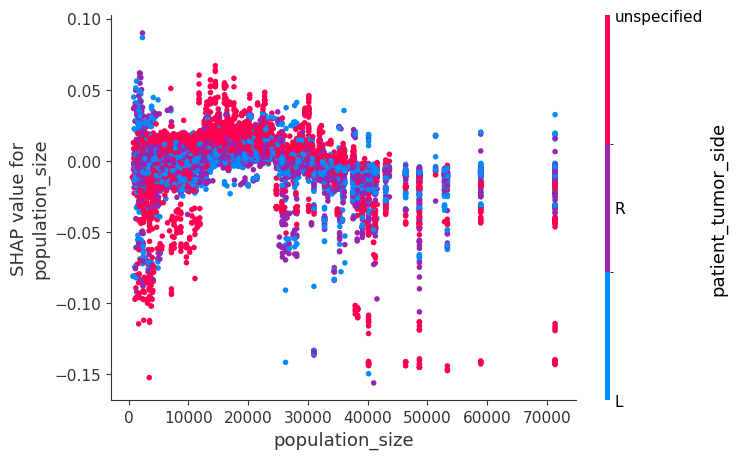

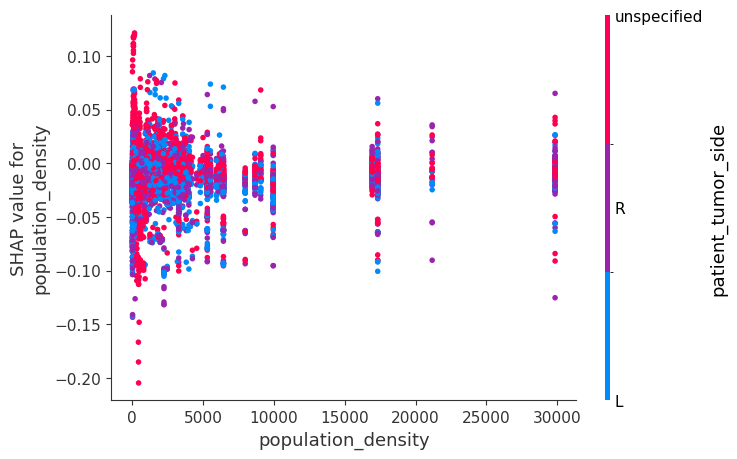

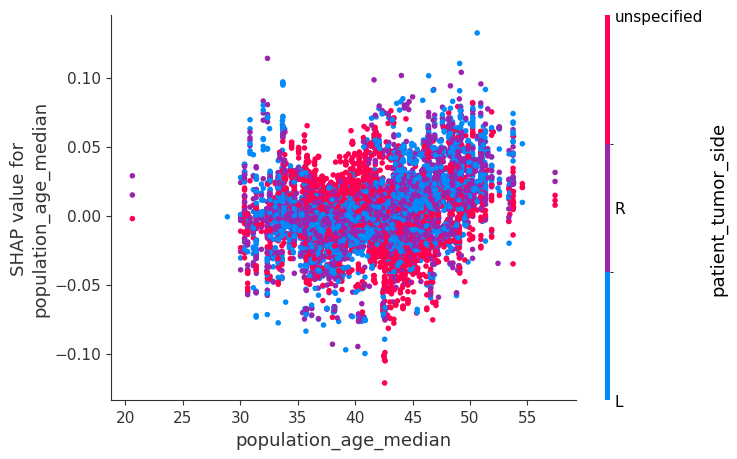

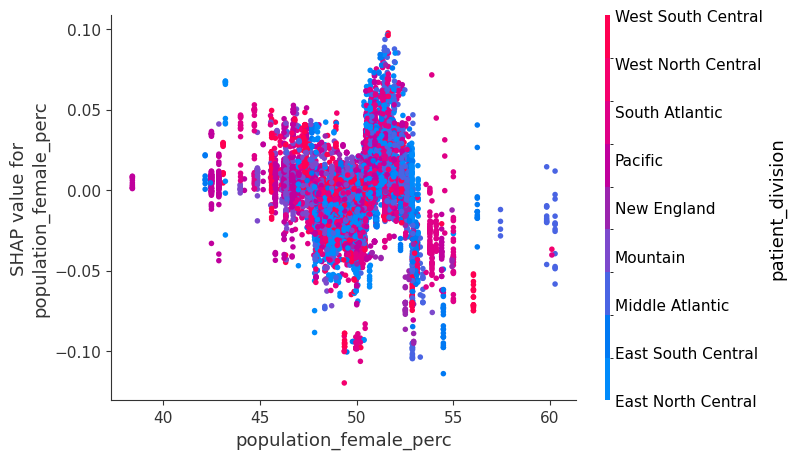

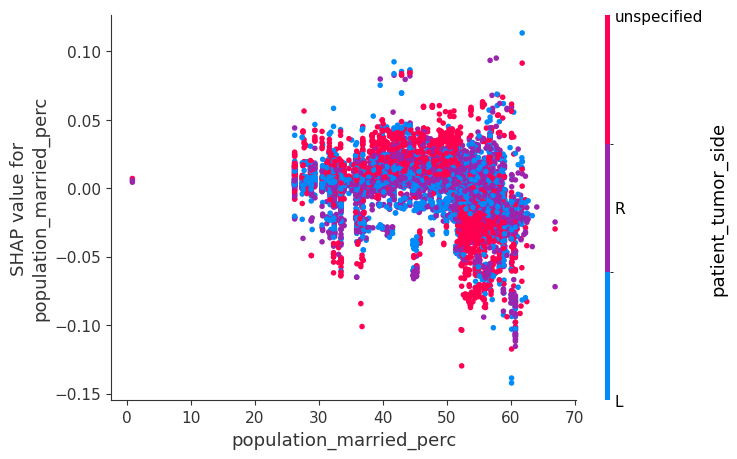

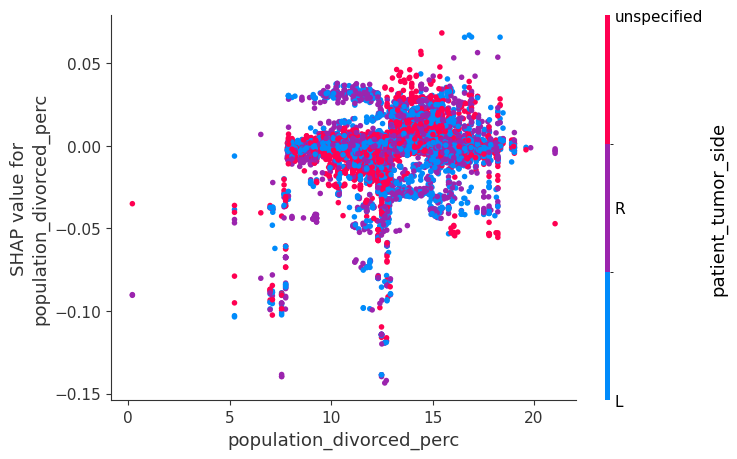

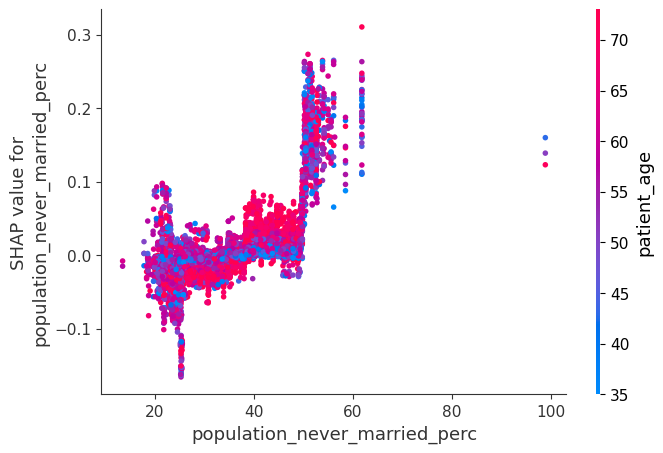

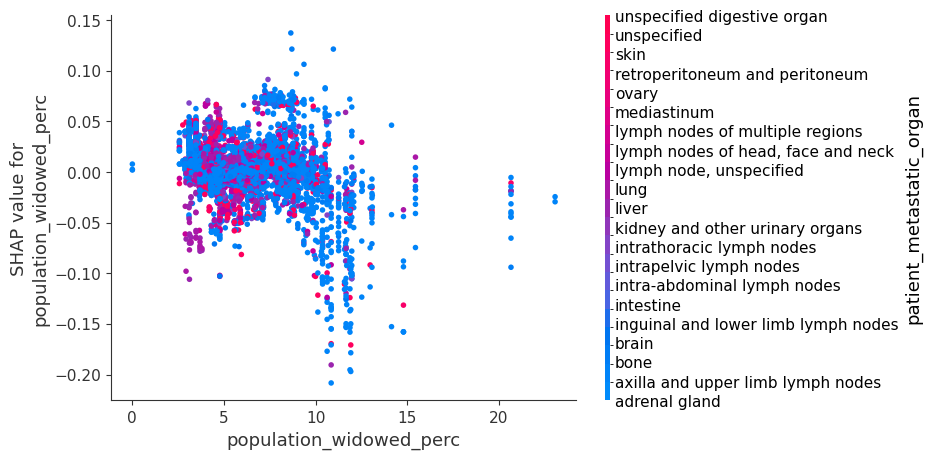

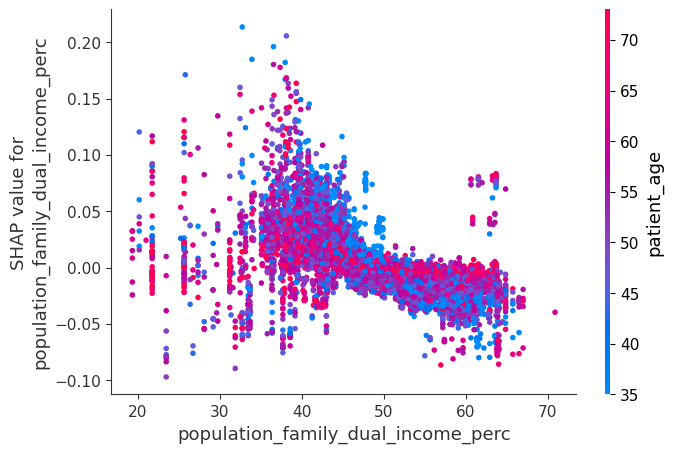

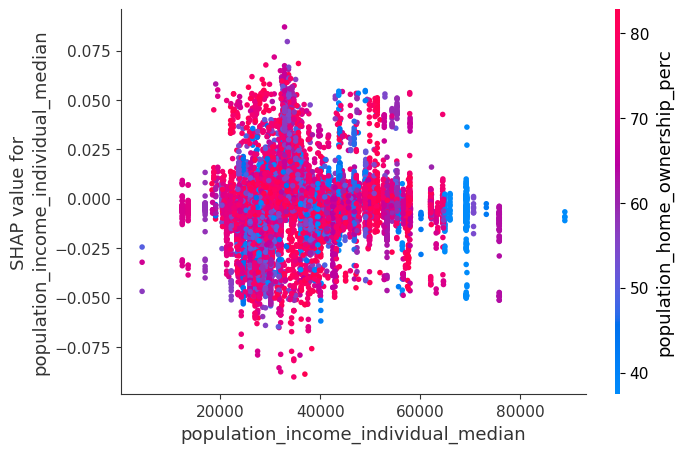

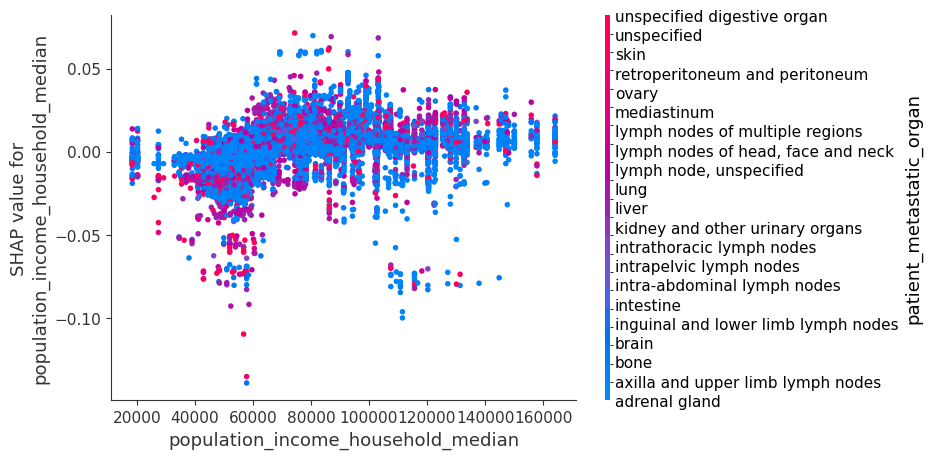

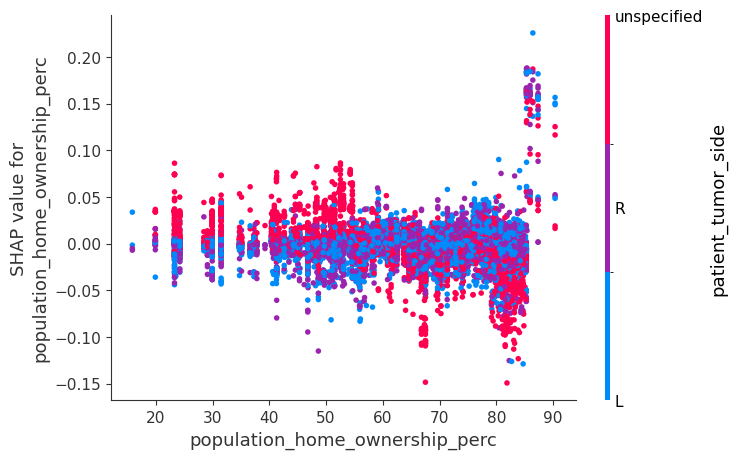

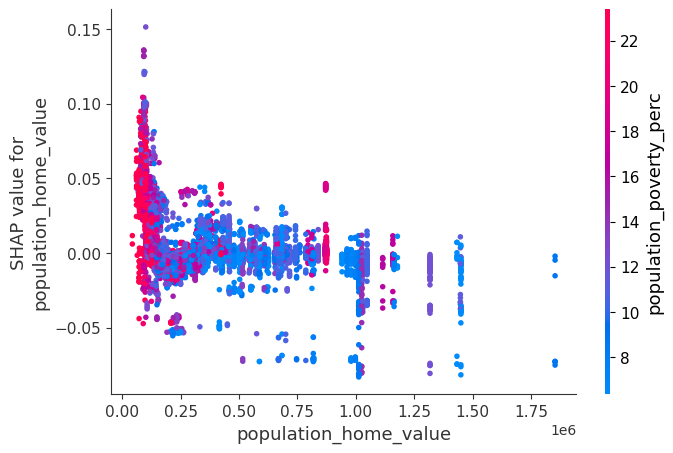

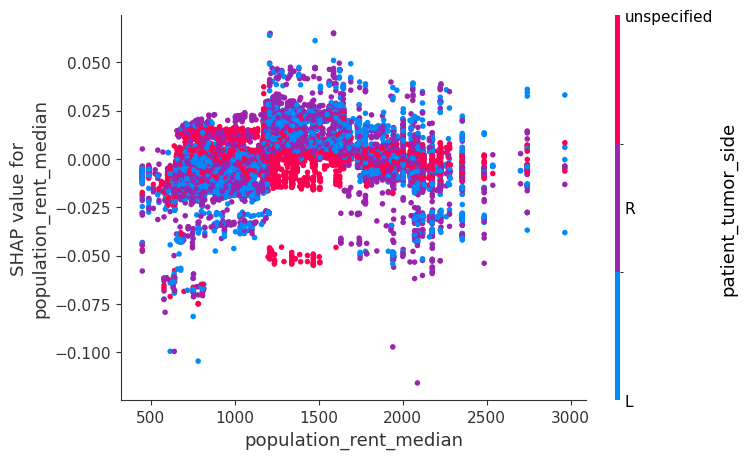

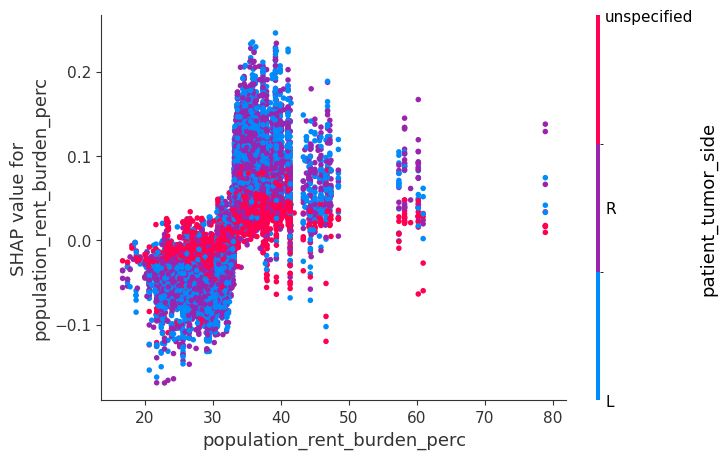

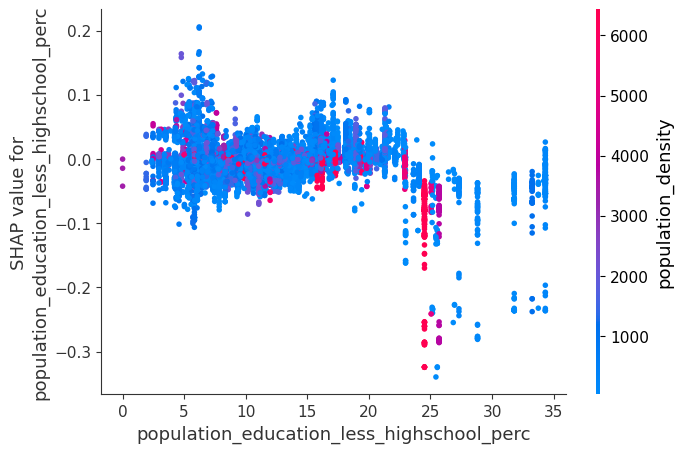

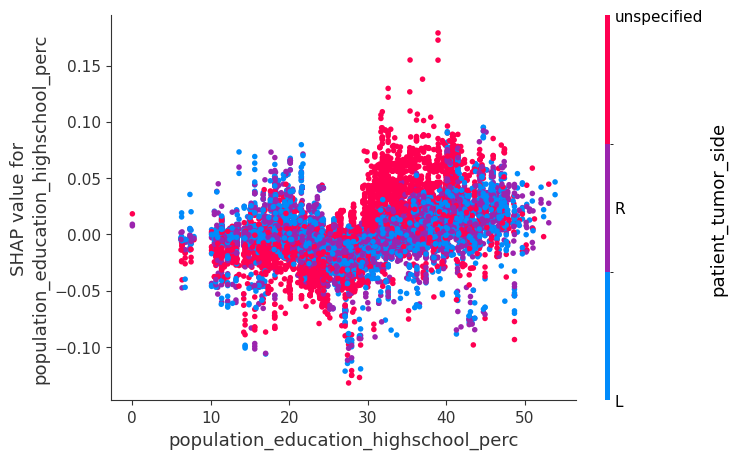

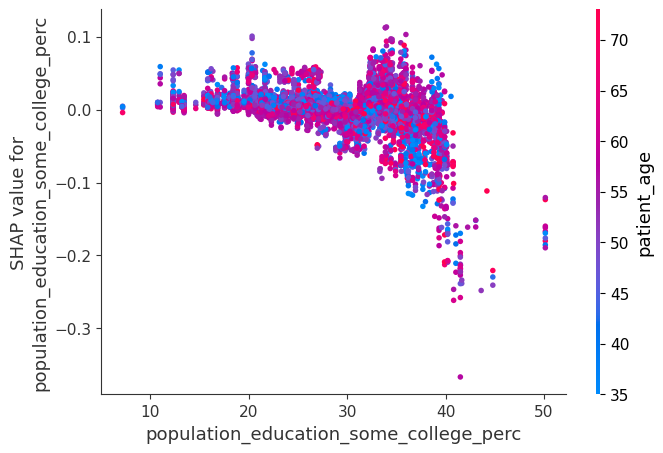

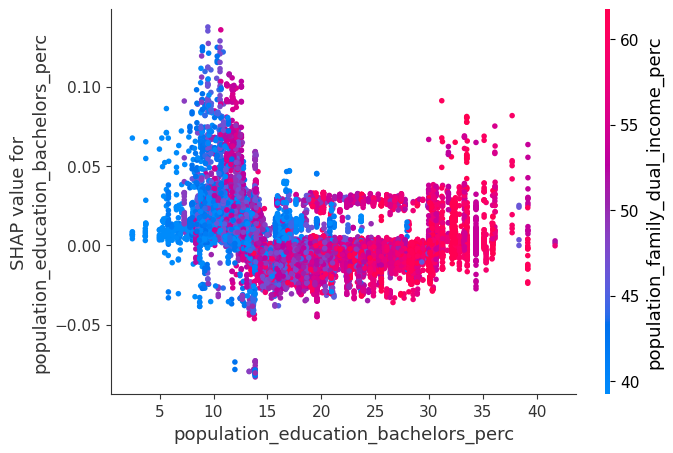

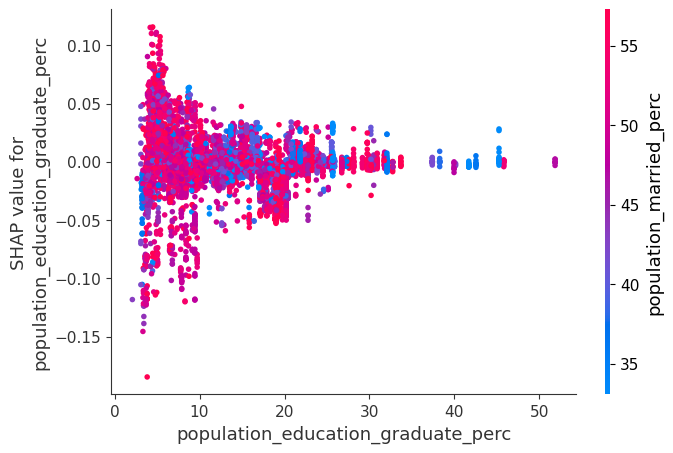

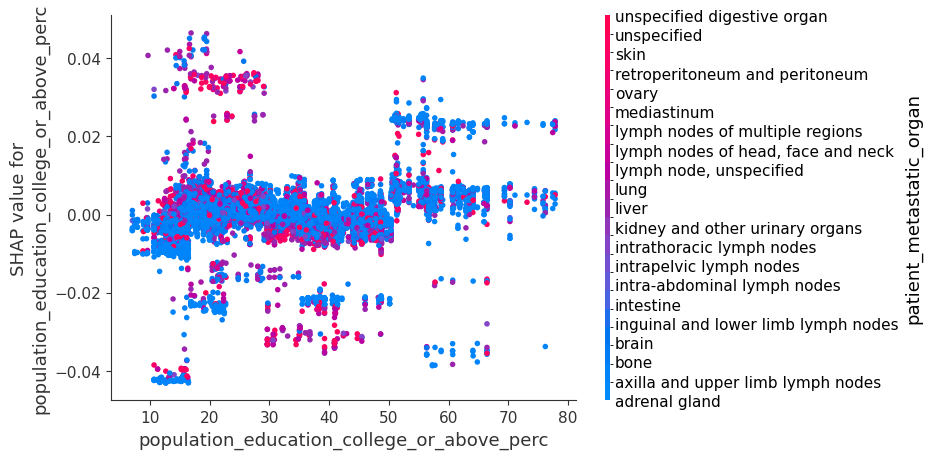

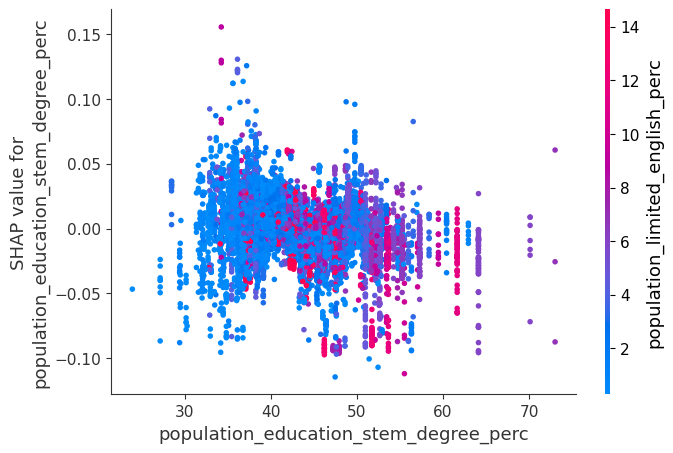

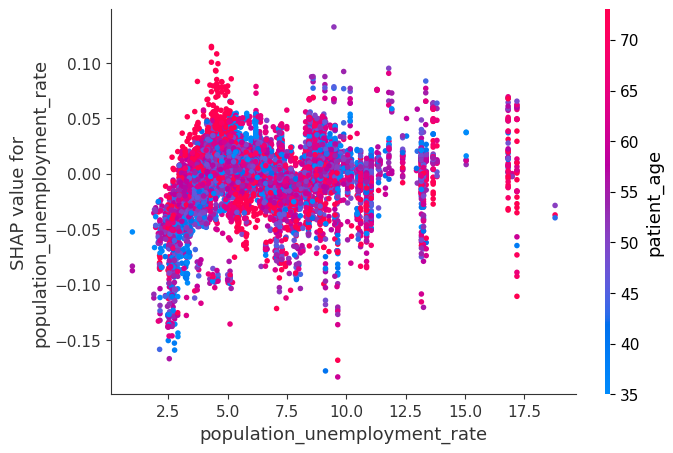

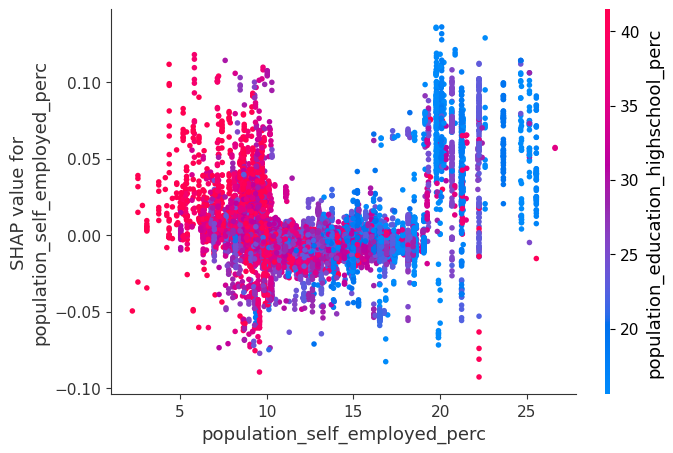

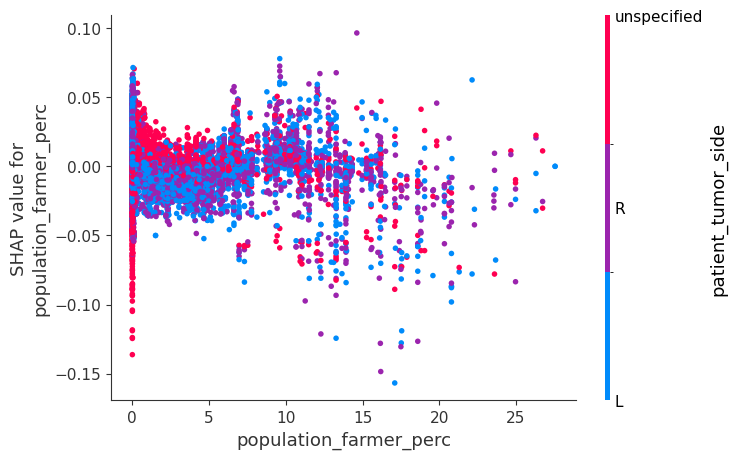

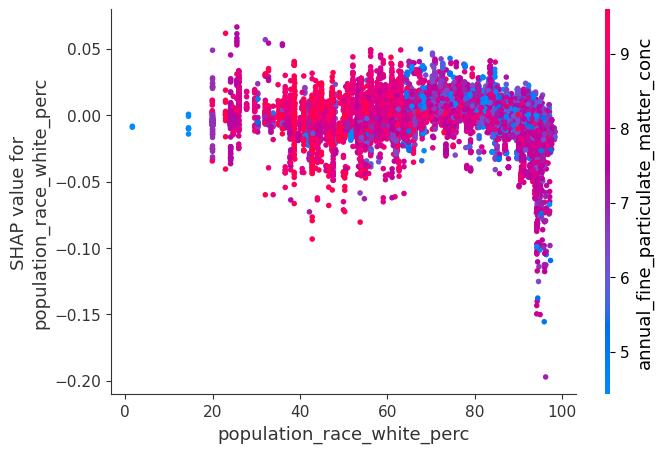

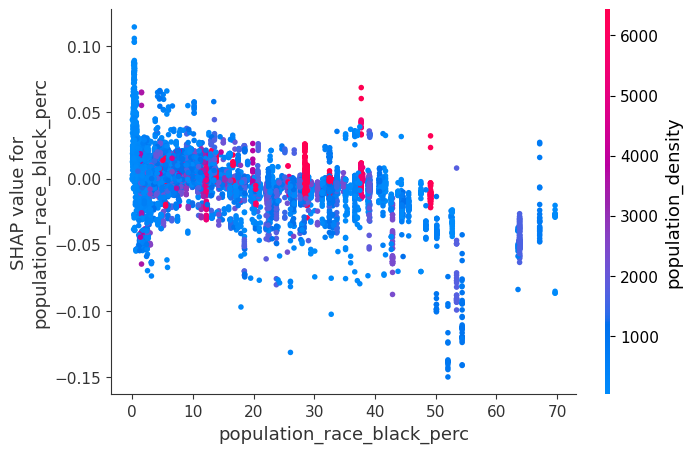

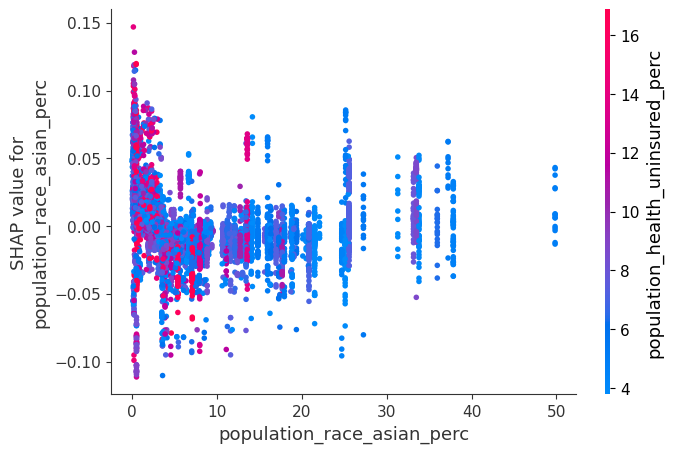

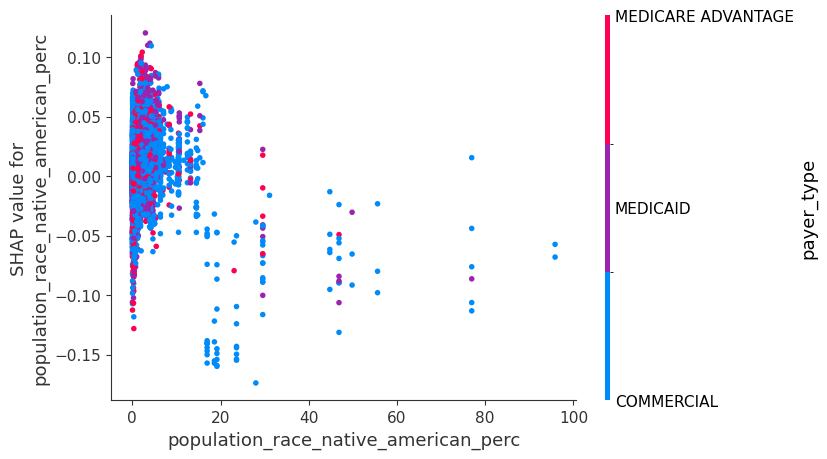

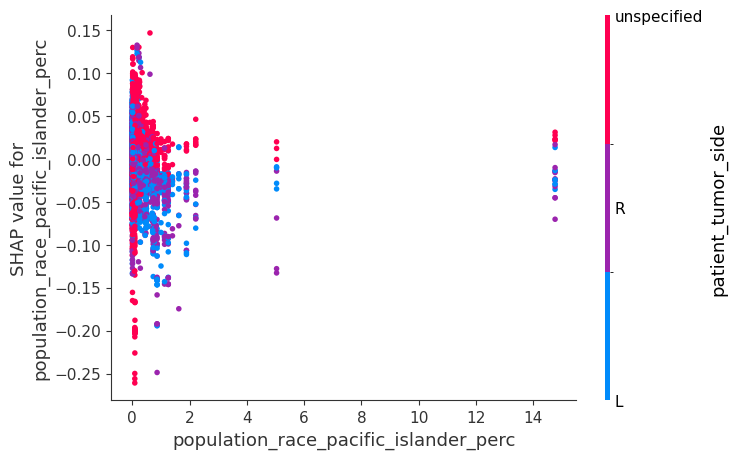

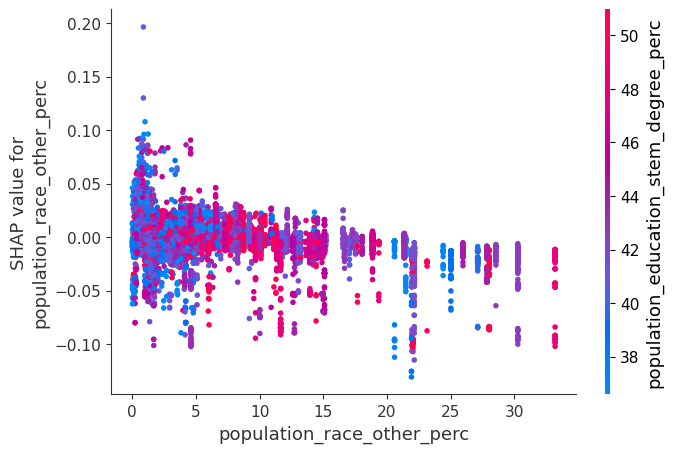

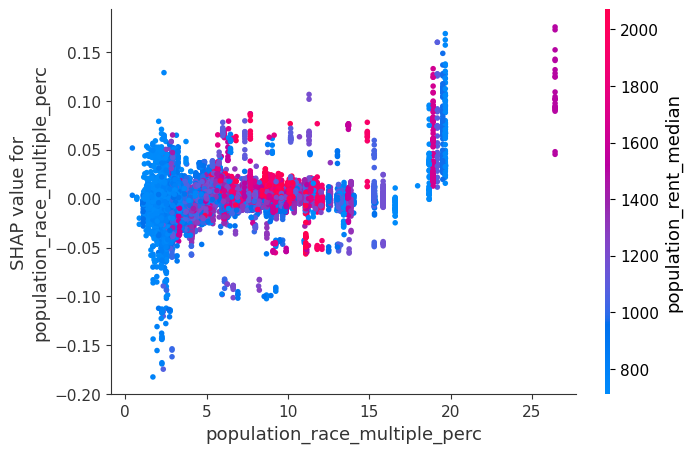

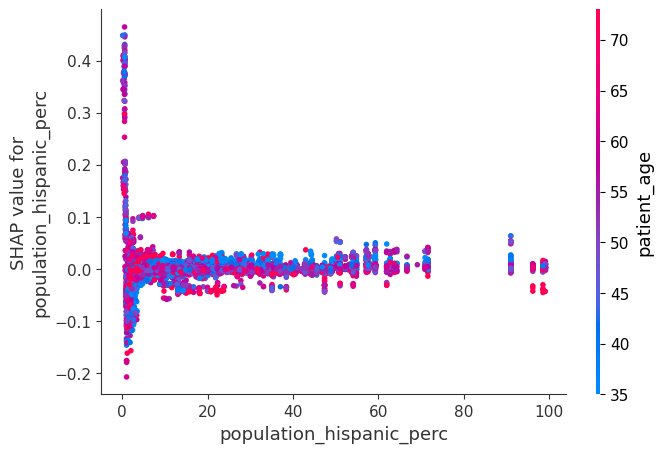

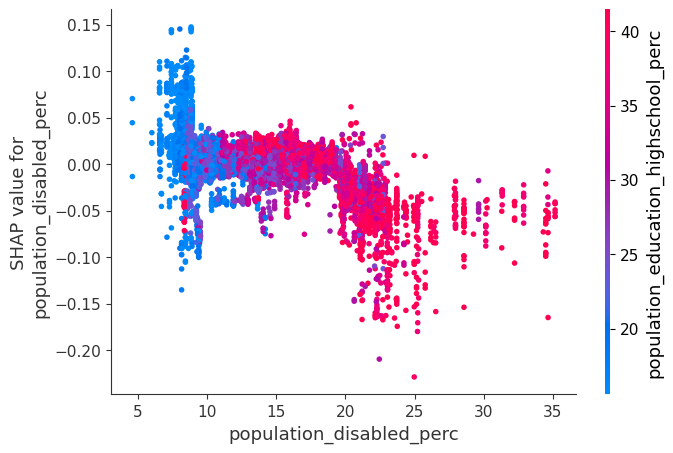

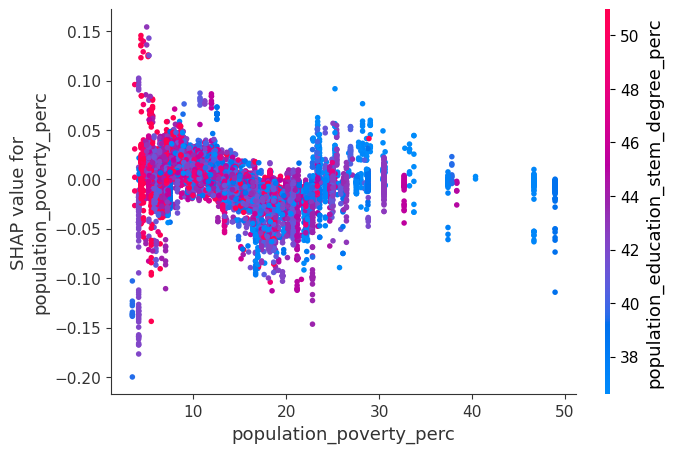

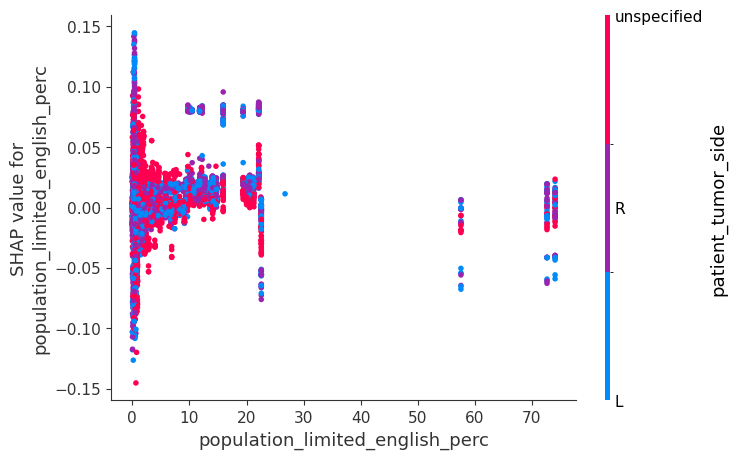

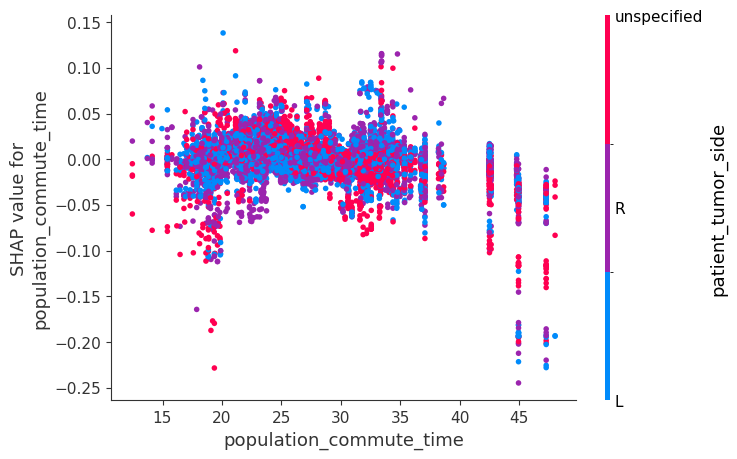

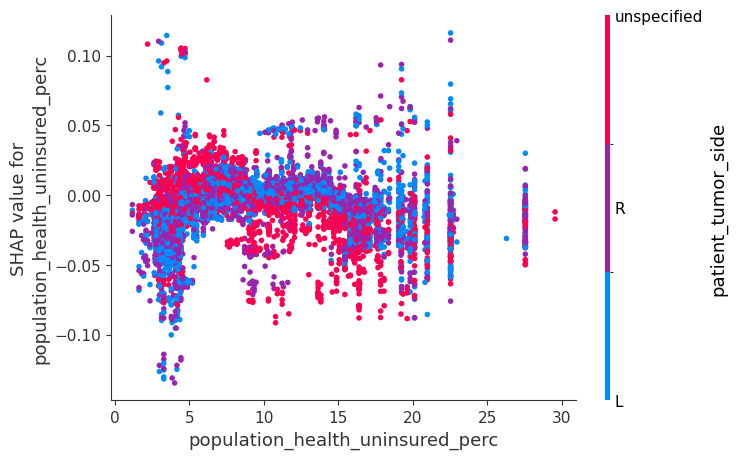

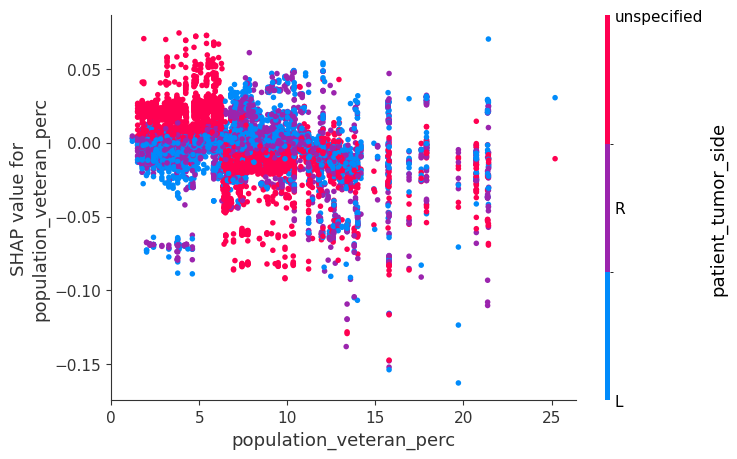

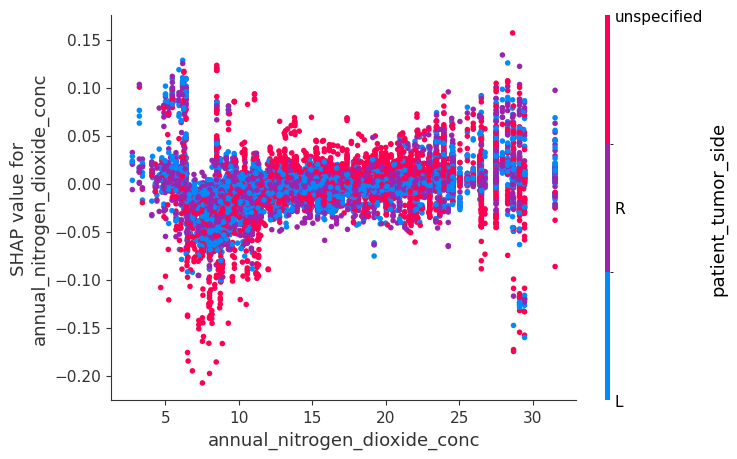

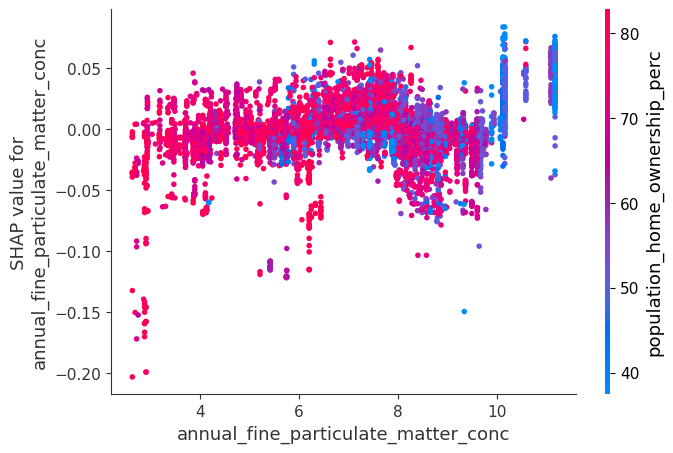

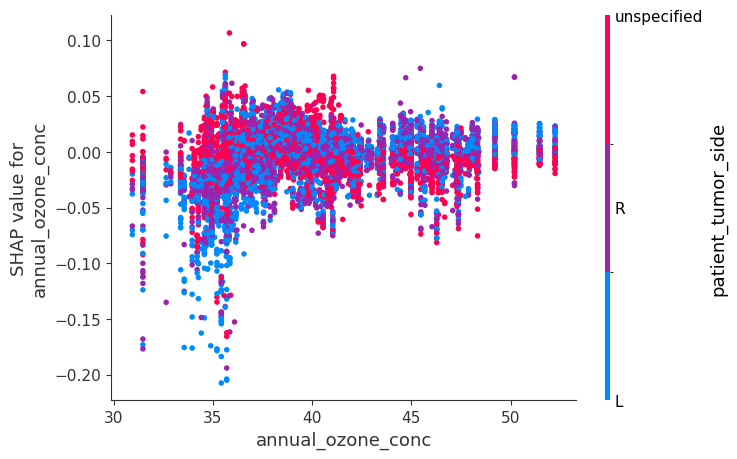

In [146]:
# Ref: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
for name in X_train_30.columns:
    shap.dependence_plot(name, shap_values.values, X)